In [1]:
!pip install rouge
!pip install hazm

In [2]:
import gdown
import time
from sklearn.model_selection import train_test_split

# Define the file URLs
file_urls = [
    "https://drive.google.com/file/d/1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8/view?usp=sharing",
    "https://drive.google.com/file/d/1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK/view?usp=sharing",
    "https://drive.google.com/file/d/1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4/view?usp=sharing",
    "https://drive.google.com/file/d/1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH/view?usp=sharing"
]

# Download files
for url in file_urls:
    file_id = url.split("/")[5]
    output_file = f"file_{file_id}.zip"  # Customize the output file name if needed
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8
To: /content/file_1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8.zip
100%|██████████| 271M/271M [00:00<00:00, 277MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK
To: /content/file_1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK.zip
100%|██████████| 18.3M/18.3M [00:00<00:00, 199MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4
To: /content/file_1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4.zip
100%|██████████| 25.9M/25.9M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH
To: /content/file_1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH.zip
100%|██████████| 96.4M/96.4M [00:00<00:00, 161MB/s]


In [3]:
import os
os.rename('/content/file_1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK.zip', '/content/test_cleaned.csv')
os.rename('/content/file_1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8.zip', '/content/train_cleaned.csv')
os.rename('/content/file_1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4.zip', '/content/word2vec-model.bin')
os.rename('/content/file_1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH.zip', '/content/allInputs.pickle')

In [4]:
import pickle
with open("allInputs.pickle", "rb") as f:
    inputs = pickle.load(f)

In [5]:
padded_inputs = inputs['input1']
padded_targets = inputs['output1']
padded_inputs_test = inputs['input2']
padded_targets_test = inputs['output2']
padded_inputs_valid = inputs['input3']
padded_targets_valid = inputs['output3']
info = inputs['info']

In [6]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, GRU, Dense
from keras.layers import RepeatVector,TimeDistributed

In [7]:
word2vec_model = Word2Vec.load('/content/word2vec-model.bin')

In [8]:
print(info)

[250, 25, 82013, 4755, 838]


In [9]:
word_vectors = word2vec_model.wv
vocab_size = len(word_vectors.key_to_index)
embedding_dim = word2vec_model.vector_size
max_length_input = info[0]
max_length_output = info[1]

In [10]:
special_end_token = '<SPECIAL_END>'
special_end_token_index = len(word_vectors.key_to_index)
special_end_token_vector = np.random.random((embedding_dim,))
word_vectors.add_vectors([special_end_token], [special_end_token_vector])
vocab_size = len(word_vectors.key_to_index)
word_vectors = word2vec_model.wv

In [11]:
def find_end_token(sequence):
    special_end_token_index=15810
    checkingloc = sequence.shape[0] - 1
    if sequence[checkingloc] != 0:
      sequence[checkingloc] = special_end_token_index
      return sequence
    while True:
      checkingloc = checkingloc - 1
      if sequence[checkingloc] != 0:
        sequence[checkingloc+1] = special_end_token_index
        return sequence
      if checkingloc == 0:
        return sequence

In [12]:
special_end_token_index = len(word_vectors.key_to_index) - 1

In [13]:
print(padded_inputs[0])

[  609 10023    61   803  1885   791  8120  1707    75  1208   123  1054
     5    19     4     6  5385  1159    75   123  1054  2158    83   123
    36 14411    75     5    19     4     6   695   823  3528   361     1
  5215   382    72  1013   341   123  1054  3066  8826   171    27   145
    90   402  1499   808   899   692  1931    83   341 10318  2897 10023
  1334  3402  1707   270    83   123  1054     5    32  2721    24    83
   270   141     0   656    83     5    19     4     6    57    83   123
  1054   636   139 11027  7711  2054   276    75   200  3482 14740    24
   459  1623    75    83  1956   649  9113  3000  1129  3556   139  1136
  1085    83   123  1054     5    19     4     6   202     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [14]:
padded_inputs = np.apply_along_axis(find_end_token, axis=1, arr=padded_inputs)
padded_targets = np.apply_along_axis(find_end_token, axis=1, arr=padded_targets)
padded_inputs_test = np.apply_along_axis(find_end_token, axis=1, arr=padded_inputs_test)
padded_targets_test = np.apply_along_axis(find_end_token, axis=1, arr=padded_targets_test)
padded_inputs_valid = np.apply_along_axis(find_end_token, axis=1, arr=padded_inputs_valid)
padded_targets_valid = np.apply_along_axis(find_end_token, axis=1, arr=padded_targets_valid)

In [15]:
print(padded_inputs[0])

[  609 10023    61   803  1885   791  8120  1707    75  1208   123  1054
     5    19     4     6  5385  1159    75   123  1054  2158    83   123
    36 14411    75     5    19     4     6   695   823  3528   361     1
  5215   382    72  1013   341   123  1054  3066  8826   171    27   145
    90   402  1499   808   899   692  1931    83   341 10318  2897 10023
  1334  3402  1707   270    83   123  1054     5    32  2721    24    83
   270   141     0   656    83     5    19     4     6    57    83   123
  1054   636   139 11027  7711  2054   276    75   200  3482 14740    24
   459  1623    75    83  1956   649  9113  3000  1129  3556   139  1136
  1085    83   123  1054     5    19     4     6   202 15810     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [16]:
# encoder input model
inputs = Input(shape=(max_length_input,))
encoder1 = Embedding(vocab_size, embedding_dim, weights=[word2vec_model.wv.vectors], trainable=False)(inputs)
encoder2 = GRU(512)(encoder1)
encoder3 = RepeatVector(max_length_output)(encoder2)
# decoder output model
decoder1 = GRU(512, return_sequences=True)(encoder3)
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder1)
# tie it together
model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 200)          3162200   
                                                                 
 gru (GRU)                   (None, 512)               1096704   
                                                                 
 repeat_vector (RepeatVector  (None, 25, 512)          0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 25, 512)           1575936   
                                                                 
 time_distributed (TimeDistr  (None, 25, 15811)        8111043   
 ibuted)                                                     

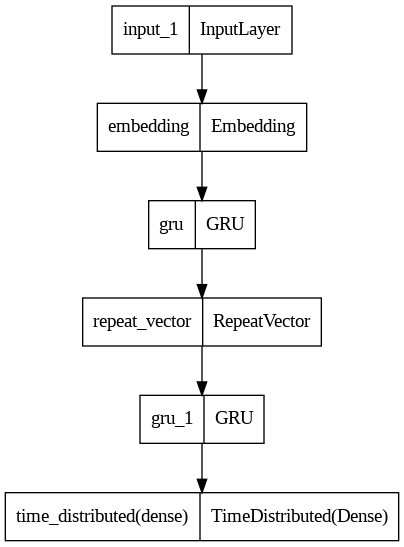

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history= model.fit(padded_inputs, padded_targets, epochs=10, batch_size=64, validation_data=(padded_inputs_valid, padded_targets_valid))

Epoch 1/10
1282/1282 [==============================] - 144s 105ms/step - loss: 5.8926 - accuracy: 0.2508 - val_loss: 5.6151 - val_accuracy: 0.2558
Epoch 2/10
1282/1282 [==============================] - 136s 106ms/step - loss: 5.3642 - accuracy: 0.2670 - val_loss: 5.2375 - val_accuracy: 0.2696
Epoch 3/10
1282/1282 [==============================] - 137s 107ms/step - loss: 5.0558 - accuracy: 0.2767 - val_loss: 5.0777 - val_accuracy: 0.2761
Epoch 4/10
1282/1282 [==============================] - 137s 107ms/step - loss: 4.8498 - accuracy: 0.2836 - val_loss: 4.8815 - val_accuracy: 0.2813
Epoch 5/10
1282/1282 [==============================] - 137s 107ms/step - loss: 4.7091 - accuracy: 0.2888 - val_loss: 4.8259 - val_accuracy: 0.2854
Epoch 6/10
1282/1282 [==============================] - 137s 107ms/step - loss: 4.5942 - accuracy: 0.2930 - val_loss: 4.7712 - val_accuracy: 0.2877
Epoch 7/10
1282/1282 [==============================] - 136s 106ms/step - loss: 4.4936 - accuracy: 0.2969 - val_

In [20]:
model.save("/content/drive/MyDrive/FinalFilesForPD/SimpleGRU.h5")

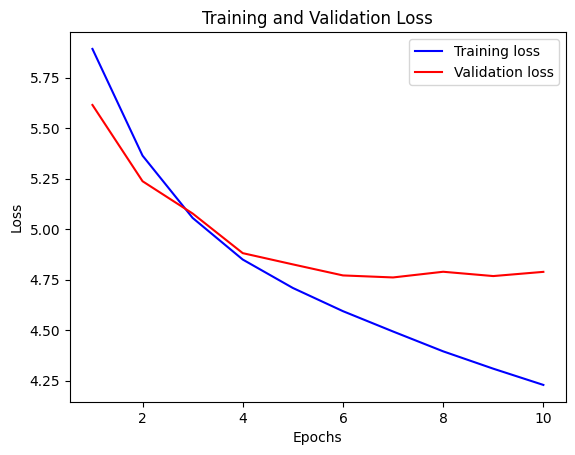

In [21]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
from rouge import Rouge

def indices_to_summary(indices, index_to_word):
    return ' '.join([index_to_word[idx] for idx in indices if idx != 0])

In [23]:
batch_size = 256

num_samples = padded_inputs_test.shape[0]
num_batches = (num_samples + batch_size - 1) // batch_size
predicted_summaries = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)

    batch_inputs = padded_inputs_test[start_idx:end_idx]

    batch_predictions = model.predict(batch_inputs)

    batch_predicted_indices = np.argmax(batch_predictions, axis=2)
    batch_predicted_summaries = [
        ' '.join([word_vectors.index_to_key[idx] for idx in indices if idx != 0])
        for indices in batch_predicted_indices
    ]

    predicted_summaries.extend(batch_predicted_summaries)


5/5 [==============================] - 1s 15ms/step


In [24]:
predicted_summaries_list = [summary.strip() for summary in predicted_summaries]

In [25]:
target_summaries = []
for targets in padded_targets_test:
    summary = ' '.join([word2vec_model.wv.index_to_key[idx] for idx in targets if idx != 0])
    target_summaries.append(summary)

In [26]:
rouge = Rouge()
null_indices = [index for index, summary in enumerate(predicted_summaries_list) if summary is None or summary == ""]
#null check:
predicted_summaries_list = [summary for index, summary in enumerate(predicted_summaries_list) if index not in null_indices]
target_summaries = [summary for index, summary in enumerate(target_summaries) if index not in null_indices]

In [27]:
scores = rouge.get_scores(predicted_summaries_list, target_summaries, avg=True)
print("ROUGE Scores:")
print(f"ROUGE-1: {scores['rouge-1']}")
print(f"ROUGE-2: {scores['rouge-2']}")
print(f"ROUGE-L: {scores['rouge-l']}")

ROUGE Scores:
ROUGE-1: {'r': 0.1625463384878176, 'p': 0.597901305600785, 'f': 0.24689928453114812}
ROUGE-2: {'r': 0.03414242223720644, 'p': 0.07769322470536442, 'f': 0.04500148502350825}
ROUGE-L: {'r': 0.15485584302979383, 'p': 0.5699340689584691, 'f': 0.23510045341339422}


In [28]:
print('hi')

hi
